In [1]:
from glob import glob
import json
import os
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib widget

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r"E:\GAT1_EEG_pilot\mouse645606\signal_test_2022-11-18_14-49-19\experiment1\recording1"
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: sensory stimulation


In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

signal_test


### Load EEG data

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [9]:
print(eeg_ts[0])
print(eeg_ts[-1])

33.12216963591622
944.3795366517253


In [10]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load LC auto-detected SWDs

In [11]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [12]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,45.741739,46.888936,1.147197,10,"[45.74173907051096, 45.868538763393985, 45.978..."
1,56.743712,58.607308,1.863595,15,"[56.74371242302699, 56.98331184270185, 57.0021..."
2,65.890090,76.445665,10.555574,70,"[65.89009026991417, 66.08968978647135, 66.2688..."
3,85.096044,88.195636,3.099592,21,"[85.09604375186498, 85.22604343699741, 85.3564..."
4,94.231622,95.322419,1.090797,12,"[94.23162162491039, 94.3380213672034, 94.43002..."


Print some stats

In [13]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 15 min recording: 127 events
Average SWD duration: 2.9 s [min=0.5, max=11.6]
Total time spent in SWD: 6.2 min


### Load RG auto-detected SWDs

In [14]:
auto_RG_file = os.path.join(exp.data_folder, r'SWD_Rong.csv')
if os.path.exists(auto_RG_file):
    print('Whoope there it is RG')
    RG_SWD_df = pd.read_csv(auto_RG_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is RG


In [16]:
print(len(RG_SWD_df))

912


In [17]:
print(len(filt_data) / exp.ephys_params['EEG']['sample_rate'])

911.2576


In [18]:
SWD_1sannot = np.array([1 if x=='SWD' else 0 for x in RG_SWD_df.Score.values])
print(np.sum(SWD_1sannot))
onsets = np.nonzero(np.diff(SWD_1sannot) == 1)[0] + 1
print(len(onsets))

388
105


In [23]:
swdtimes = []
for indi in onsets:
    starti = eeg_ts[indi * exp.ephys_params['EEG']['sample_rate']]
    bindi = indi + 1
    if bindi < len(SWD_1sannot):
        while SWD_1sannot[bindi] == 1:
            bindi += 1
        endi = eeg_ts[bindi * exp.ephys_params['EEG']['sample_rate']]
    else:
        endi = eeg_ts[-1]
    swdtimes.append([starti, endi])

RG_events = pd.DataFrame(swdtimes, columns=['onset', 'offset'])
RG_events['duration'] = RG_events['offset'] - RG_events['onset']
RG_events.head()

,onset,offset,duration
0,46.122138,47.122136,0.999998
1,57.122112,58.122109,0.999998
2,66.122090,76.122065,9.999976
3,85.122044,88.122036,2.999993
4,94.122022,95.122019,0.999998


### Plot both annotated events

Text(0.5, 1.0, 'Mouse 645606: signal_test')

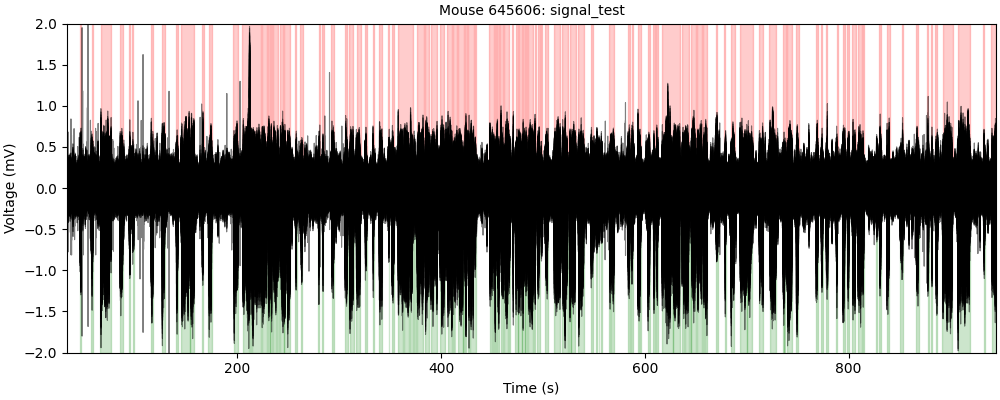

In [24]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)

ax.plot(eeg_ts, filt_data, color='k', linewidth=0.8, alpha=0.5)
for ii, Lrow in autoSWD_df.iterrows():
    ax.axvspan(Lrow.onset, Lrow.offset, ymin=0, ymax=0.5, color='g', alpha=0.2)
for jj, Rrow in RG_events.iterrows():
    ax.axvspan(Rrow.onset, Rrow.offset, ymin=0.5, ymax=1, color='r', alpha=0.2)
ax.set_xlim([eeg_ts[0], eeg_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylim([-2.0, 2.0])
ax.set_ylabel('Voltage (mV)')
ax.set_title('Mouse {}: {}'.format(exp.mouse, exp_tag))

Turns out that my auto-annotated SWDs match Rong's very well.